<div style="background-image:url(images/bertinoro.jpg); padding: 10px 30px 20px 30px; background-size:cover; background-opacity:50%; border-radius:5px">
<p style="float:right; margin-top:20px; padding: 20px 20px 0px 20px; background:rgba(255,255,255,0.6); border-radius:10px;">
<img width="400px" src=images/obspy_logo_full_524x179px.png?raw=true>
</p>

<h1 style="color:#333">First TIDES Training School</h1>
<h5 style="color:#FFF">Bertinoro (FC), Italy, June 1-5 2015</h5>

<h3 style="color:#EEE">Day 1: Data Acquisition and Processing with ObsPy</h3>

<h2 style="color:#FFF">Plotting yearly ambient noise spectra</h2>
</div>

In the practical on Tuesday we will look at how the spectral content of ambient noise changes with time. In this notebook, we will access several years of continuous data and plot its spectrum as a function of time. 

In [1]:
%pylab inline
from __future__ import print_function
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import obspy
from obspy.fdsn import Client
from obspy import UTCDateTime

import os
import glob
noise_folder = "/home/tides/Desktop/data/noise_data"

- The data can be accessed through the INGV web service.  
- We will use station **"IV.TEOL"** in Northern Italy. (Alternatively, data for station **"MN.VLC"** is also available on the virtial box.)
- First, let's have a look at this station's response:

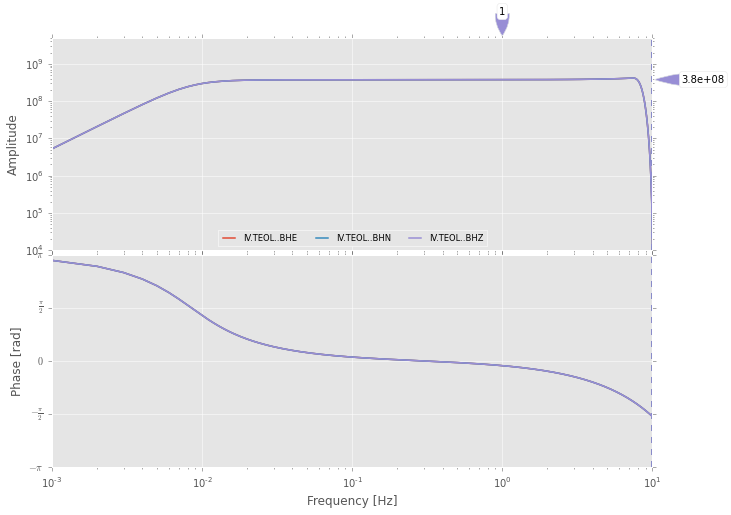

In [3]:
client = Client("INGV")
station = 'TEOL' #'VLC'
network = 'IV'   #'MN'

# get the instrument response
inv = client.get_stations(network=network, station=station, channel="BH?", level="response")
inv.plot_response(0.001);

##Step 1: Download the data
- Since it would take too long to download 2 full years of data, we will only use one out of ten days
- Make a list of UTCDateTime objects, picking one date every ten days between 2012.01.01 and 2013.12.31
- The daily spectra will be calculated over a window length of two hours

In [4]:
startdate = UTCDateTime(2012,1,1)
enddate = UTCDateTime(2013,12,31)
date = startdate

ndays = 10
window_length = 7200 


dates = []
_i = 1

while date < enddate:
    date = date + ndays * 86400
    dates.append(date)

###Option 1: Download the data from the INGV webservice:
You can **uncomment the following block** of code to download the data. However, if everyone tries to do this at the same time, we might run in to problems. The raw data for 10 days per season is therefore also provided on the virtual box. A bit further down in this notebook, you can also choose to read the provided data from disk (see **option 2**). 

- Now download the Z-component record for each of the days defined above

In [5]:
two_years_st = obspy.Stream()

print("Downloading data....")

for date in dates:
    try:
        two_years_st += client.get_waveforms(network=network, station=station, location="", channel="BHZ",
                                             starttime=date, endtime=date+window_length+3600)
    except:
        print("No data for %s" % date.strftime("%Y-%m-%d"))
        pass

sts = two_years_st.copy()
sts.attach_response(inv)

print("Data is downloaded. Available waveforms: \n", two_years_st)

No data for 2012-09-07
Data is downloaded. Available waveforms: 
 118 Trace(s) in Stream:

IV.TEOL..BHZ | 2012-01-10T23:59:53.795200Z - 2012-01-11T03:00:07.345200Z | 20.0 Hz, 216272 samples
...
(116 other traces)
...
IV.TEOL..BHZ | 2013-12-30T23:59:44.845000Z - 2013-12-31T03:00:09.295000Z | 20.0 Hz, 216490 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


- Uncomment the folowing to save the raw data you just downloaded:

In [6]:
spec_folder = os.path.join(noise_folder, 'spectra', "%s-%s-%s" % (dates[0].year, dates[-1].year, station))
if not os.path.exists(spec_folder):
        os.makedirs(spec_folder)

for tr in sts: 
    filename = tr.id + tr.stats.starttime.strftime("_%Y.%m.%d-%H.%M") + ".SAC"
    tr.write(os.path.join(spec_folder, filename), format="SAC") 
    
print("Done. Data written to: ", spec_folder)

Done. Data written to:  /home/tides/Desktop/data/noise_data/spectra/2012-2013-TEOL


### Option 2: read the data from disk:

- This will read the data which is already stored on the virtual box, instead of downloading.   
If you are using **option 1** above, comment out this block!



In [7]:
#two_years_st = obspy.Stream()
#
#spec_folder = os.path.join(noise_folder, 'spectra', "%s-%s-%s" % (dates[0].year, dates[-1].year, station))
#list = glob.glob(os.path.join(spec_folder, "*%s*.SAC" % station))
#
#for filename in list:
#    two_years_st += obspy.read(filename)
#    
#sts = two_years_st.copy()
#sts.sort()
#sts.attach_response(inv)
#
#print("Finished reading data from %s. \nAvailable waveforms: \n" % spec_folder, sts)

- Set the frequency ranges for the filter to use before removing instrument response:


In [8]:
f2 = 1.0 / 400.0 #max period
f3 = 1.0 / 3.0 #min period
f1 = 0.8 * f2
f4 = 1.2 * f3
pre_filt = (f1, f2, f3, f4)

## Step 2: compute the spectra
- Calculate the spectrum for a set of windows in each of the days (this takes a while..)

In [9]:
spectra = []
times = []

print("Computing spectra.... ")

for date in dates:
    if date + window_length < sts[-1].stats.endtime:
        st_x = sts.slice(starttime=date, endtime=date + window_length)
        if not st_x:
            continue
                           
        else:            
            st_x.merge(fill_value='interpolate')

            if abs(st_x[0].stats.starttime - st_x[-1].stats.endtime) < 0.9 * window_length:
                break

            st_x.remove_response(pre_filt=pre_filt, output="DISP", 
                                 water_level=60.0, zero_mean=True, taper=True)
            spectra.append(np.abs(np.fft.rfft(st_x[0].data)))
            times.append(st_x[0].stats.starttime + 0.5 * (st_x[-1].stats.endtime - st_x[0].stats.starttime))
            freqs = np.fft.rfftfreq(st_x[0].stats.npts) * st_x[0].stats.sampling_rate
        
# gather all the individual spectra into an array:     
spec_array = np.concatenate(spectra)
spec_array.shape = (len(spectra), len(spectra[0]))

print("Done. Spectra are computed for %s days between %s and %s" \
      % (len(spectra), startdate.strftime("%Y-%m-%d"), enddate.strftime("%Y-%m-%d")))

Computing spectra.... 
Done. Spectra are computed for 40 days between 2012-01-01 and 2013-12-31


- Plot a single spectrum

[]

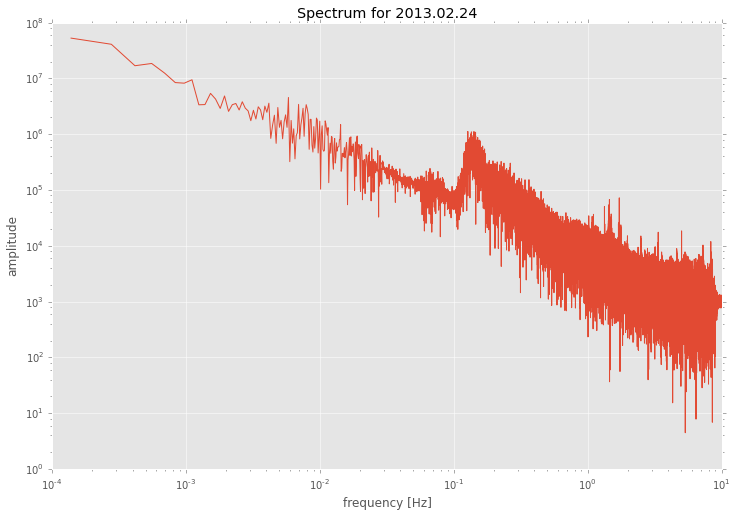

In [10]:
st_s = sts.slice(starttime=dates[0], endtime=dates[0] + window_length)

spec = np.abs(np.fft.rfft(st_s[0].data))
plt.loglog(np.fft.rfftfreq(st_s[0].stats.npts) * st_s[0].stats.sampling_rate, spec)
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude')
plt.title('Spectrum for %s' % date.strftime('%Y.%m.%d'))

plt.plot()

##Step 3: Plot!

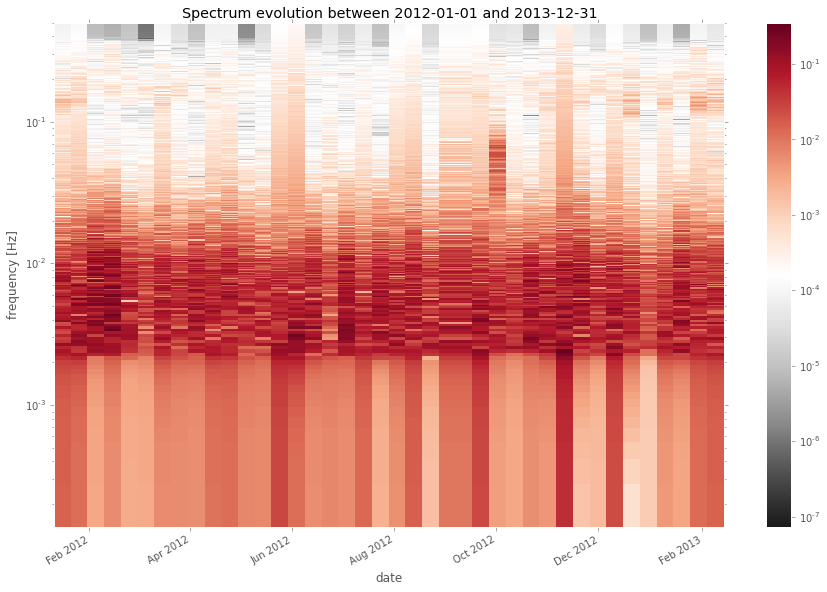

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.colors import LogNorm


mtimes = matplotlib.dates.date2num([_i.datetime for _i in times])

y = freqs

plt.figure(figsize=(15, 10))
plt.pcolormesh(mtimes, y, spec_array.T, norm=LogNorm(vmin=spec_array.min(), 
                                                     vmax=spec_array.max()), cmap='RdGy_r')
plt.yscale("log")
plt.gca().xaxis_date()
plt.gcf().autofmt_xdate()
plt.xlim(mtimes[0], mtimes[-1])
plt.colorbar()
plt.ylim(y[1], 0.5)
plt.xlabel('date')
plt.ylabel('frequency [Hz]')
plt.title('Spectrum evolution between %s and %s' \
          %(startdate.strftime('%Y-%m-%d'), enddate.strftime('%Y-%m-%d')))
plt.show()